In [1]:
import glob

import torch
import numpy as np
from scipy.io import loadmat, savemat
from scipy.signal import resample

from timedenoiser.models.cnn import ShallowCNN
from timedenoiser.models.encdec import *
from timedenoiser.models.unet import UNET_1D
from timedenoiser.models.ekf import ekf
from timedenoiser.models.tv1d import tv
from timedenoiser.models.wt import wt

from motormetrics.ml import *
from motormetrics.ee import *
from motormetrics.ee import get_ramp_from_sim_reference

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
model_id = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_ud = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_uq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')

# model_id = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

# model_id = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.01_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_id.eval()
model_iq.eval()
model_ud.eval()
model_uq.eval()

model_spd = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_current_d,current_q,voltage_d,voltage_q_outQuants_speed_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
model_trq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_current_d,current_q,voltage_d,voltage_q_outQuants_torque_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_spd.eval()
model_trq.eval()

model_spd_n = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d,noisy_current_q,noisy_voltage_d,noisy_voltage_q_outQuants_speed_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
model_trq_n = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d,noisy_current_q,noisy_voltage_d,noisy_voltage_q_outQuants_torque_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_spd_n.eval()
model_trq_n.eval()

ShallowEncDec(
  (cnn1): Conv1d(4, 32, kernel_size=(10,), stride=(1,))
  (cnn2): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (cnn3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (cnn4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (dcnn4): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(1,))
  (dcnn3): ConvTranspose1d(128, 64, kernel_size=(5,), stride=(1,))
  (dcnn2): ConvTranspose1d(64, 32, kernel_size=(7,), stride=(1,))
  (dcnn1): ConvTranspose1d(32, 1, kernel_size=(10,), stride=(1,))
  (act): ReLU()
)

In [3]:
class Exper():
        def __init__(self, kwargs):
            for k in kwargs:
                self.__dict__[k] = kwargs[k]
                
def compute_ml(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    print ('Speed')
    print ('SMAPE :', smape(speed_pred, ndata['speed']))
    print ('R2 :', r2(speed_pred, ndata['speed']))
    print ('RMSE :', rmse(speed_pred, ndata['speed']))
    print ('MAE :', mae(speed_pred, ndata['speed']))

    print ('Torque')
    print ('SMAPE :', smape(torque_pred, ndata['torque']))
    print ('R2 :', r2(torque_pred, ndata['torque']))
    print ('RMSE :', rmse(torque_pred, ndata['torque']))
    print ('MAE :', mae(torque_pred, ndata['torque']))
    
def compute_ee(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    ndata['speed'] = speed_pred
    ndata['torque'] = torque_pred
    model_exp = Exper(ndata)

    model_torque_metrics = compute_torque_metrics(model_exp)
    model_speed_metrics = compute_speed_metrics(model_exp)

    print (model_speed_metrics)
    print (model_torque_metrics)

In [4]:
data1 = loadmat('../../../datasets/Data_27012021_noisy/benchmark/real3.mat')
data2 = loadmat('../../../datasets/Data_27012021_noisy/real/OFVC4kW_NoLM_SpeedVariations2_20190419_Data.mat')

data2n = {}
for k in data2.keys():
    if '__' not in k and 'time' not in k:
        new_quant = data2[k]
        for x in [5693,  5694,  7563,  7565,  8499,  8519,  9449,  9452, 10362,12237, 20640, 21573, 21595]:
            new_quant[0, x] = new_quant[0, x-1]
        data2n[k] = new_quant

data2n['time'] = data2['time']
data2 = data2n

st = 0
et = -1

x_id = np.stack([data2['noisy_current_d'][0] / 30]) 
x_iq = np.stack([data2['noisy_current_q'][0] / 30])
x_ud = np.stack([data2['noisy_voltage_d'][0] / 300]) 
x_uq = np.stack([data2['noisy_voltage_q'][0] / 300])

x_d = np.stack([[x_id[0], x_iq[0], x_ud[0], x_uq[0]]])


inp_id = torch.tensor([x_id[:, st:et]]).cuda().float()
out_id = model_id(inp_id)
out_id_da = out_id.data.cpu().numpy()[0]
out_id_wt = wt(data2['noisy_current_d'][0], 0.17)
out_id_ekf = ekf(data2['noisy_current_d'][0], 0.17)
out_id_tv = tv(data2['noisy_current_d'][0], 0.17)

inp_iq = torch.tensor([x_iq[:, st:et]]).cuda().float()
out_iq = model_iq(inp_iq)
out_iq_da = out_iq.data.cpu().numpy()[0]
out_iq_wt = wt(data2['noisy_current_q'][0], 0.29)
out_iq_ekf = ekf(data2['noisy_current_q'][0], 0.29)
out_iq_tv = tv(data2['noisy_current_q'][0], 0.29)

inp_ud = torch.tensor([x_ud[:, st:et]]).cuda().float()
out_ud = model_ud(inp_ud)
out_ud_da = out_ud.data.cpu().numpy()[0]
out_ud_wt = wt(data2['noisy_voltage_d'][0], 1.85)
out_ud_ekf = ekf(data2['noisy_voltage_d'][0], 1.85)
out_ud_tv = tv(data2['noisy_voltage_d'][0], 1.85)

inp_uq = torch.tensor([x_uq[:, st:et]]).cuda().float()
out_uq = model_uq(inp_uq)
out_uq_da = out_uq.data.cpu().numpy()[0]
out_uq_wt = wt(data2['noisy_voltage_q'][0], 1.78)
out_uq_ekf = ekf(data2['noisy_voltage_q'][0], 1.78)
out_uq_tv = tv(data2['noisy_voltage_q'][0], 1.78)

inps_da = torch.from_numpy(np.stack([[out_id_da[0], 
                                       out_iq_da[0], 
                                       out_ud_da[0], 
                                       out_uq_da[0]]])).cuda()
inps_wt = torch.from_numpy(np.stack([[out_id_wt / 30, 
                                       out_iq_wt / 30, 
                                       out_ud_wt / 300, 
                                       out_uq_wt / 300]])).cuda().float()
inps_ekf = torch.from_numpy(np.stack([[out_id_ekf / 30, 
                                       out_iq_ekf / 30, 
                                       out_ud_ekf / 300, 
                                       out_uq_ekf / 300]])).cuda().float()
inps_tv = torch.from_numpy(np.stack([[out_id_tv / 30, 
                                       out_iq_tv / 30, 
                                       out_ud_tv / 300, 
                                       out_uq_tv / 300]])).cuda().float()
inps_d = torch.from_numpy(x_d).cuda().float()

out_spd_da = model_spd(inps_da)
out_spd_da = out_spd_da.data.cpu().numpy()[0]
out_spd_wt = model_spd(inps_wt)
out_spd_wt = out_spd_wt.data.cpu().numpy()[0]
out_spd_ekf = model_spd(inps_ekf)
out_spd_ekf = out_spd_ekf.data.cpu().numpy()[0]
out_spd_tv = model_spd(inps_tv)
out_spd_tv = out_spd_tv.data.cpu().numpy()[0]
out_spd_d = model_spd_n(inps_d)
out_spd_d = out_spd_d.data.cpu().numpy()[0]

out_trq_da = model_trq(inps_da)
out_trq_da = out_trq_da.data.cpu().numpy()[0]
out_trq_wt = model_trq(inps_wt)
out_trq_wt = out_trq_wt.data.cpu().numpy()[0]
out_trq_ekf = model_trq(inps_ekf)
out_trq_ekf = out_trq_ekf.data.cpu().numpy()[0]
out_trq_tv = model_trq(inps_tv)
out_trq_tv = out_trq_tv.data.cpu().numpy()[0]
out_trq_d = model_trq(inps_d)
out_trq_d = out_trq_d.data.cpu().numpy()[0]

In [5]:
alpha = 0.1
speed_pred_d = out_spd_d[0] * 80
speed_pred_d = alpha * speed_pred_d + (1 - alpha) * data2['speed'][0]

torque_pred_d = out_trq_d[0] * 120
torque_pred_d = alpha * torque_pred_d + (1 - alpha) * data2['torque'][0]

alpha = 0.01
speed_pred_md = np.copy(data2['speed'][0])
speed_pred_md[:-1] = out_spd_da[0] * 80
speed_pred_md = alpha * speed_pred_md + (1 - alpha) * data2['speed'][0]

torque_pred_md = np.copy(data2['torque'][0])
torque_pred_md[:-1] = out_trq_da[0] * 120
torque_pred_md = alpha * torque_pred_md + (1 - alpha) * data2['torque'][0]


alpha = 0.09
speed_pred_da = np.copy(data2['speed'][0])
speed_pred_da[:-1] = out_spd_da[0] * 80
speed_pred_da = alpha * speed_pred_da + (1 - alpha) * data2['speed'][0]

torque_pred_da = np.copy(data2['torque'][0])
torque_pred_da[:-1] = out_trq_da[0] * 120
torque_pred_da = alpha * torque_pred_da + (1 - alpha) * data2['torque'][0]

alpha = 0.14
speed_pred_wt = out_spd_wt[0] * 80
speed_pred_wt = alpha * speed_pred_wt + (1 - alpha) * data2['speed'][0]

torque_pred_wt = out_trq_wt[0] * 120
torque_pred_wt = alpha * torque_pred_wt + (1 - alpha) * data2['torque'][0]

alpha = 0.15
speed_pred_ekf = out_spd_ekf[0] * 80
speed_pred_ekf = alpha * speed_pred_ekf + (1 - alpha) * data2['speed'][0]

torque_pred_ekf = out_trq_ekf[0] * 120
torque_pred_ekf = alpha * torque_pred_ekf + (1 - alpha) * data2['torque'][0]

alpha = 0.1
speed_pred_tv = out_spd_tv[0] * 80
speed_pred_tv = alpha * speed_pred_tv + (1 - alpha) * data2['speed'][0]

torque_pred_tv = out_trq_tv[0] * 120
torque_pred_tv = alpha * torque_pred_tv + (1 - alpha) * data2['torque'][0]

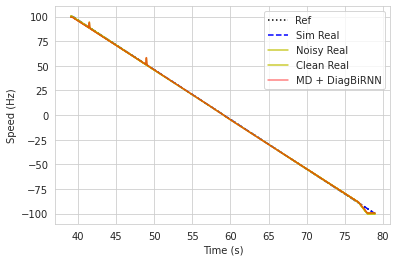

In [6]:
st = int(39 / 0.004)
et = int(79 / 0.004)

sns.set_style("whitegrid")
plt.plot(data1['time'][0, st:et], data1['reference_speed_interp'][0, st:et], 'k:', label="Ref")
plt.plot(data1['time'][0, st:et], data1['speed'][0, st:et], 'b--', label="Sim Real")
plt.plot(data1['time'][0, st:et], data2['noisy_speed'][0, st:et], 'y', label="Noisy Real", alpha=0.8)
plt.plot(data1['time'][0, st:et], data2['speed'][0, st:et], 'y', label="Clean Real", alpha=0.8)
plt.plot(data1['time'][0, st:et], speed_pred_md[st:et], 'r', label="MD + DiagBiRNN", alpha=0.5)

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Speed (Hz)')
# plt.plot()
plt.show() 
# plt.savefig('real3_spd.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
# plt.close()

# st = int(5 / 0.004)
# et = int(55 / 0.004)
# sns.set_style("whitegrid")
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(data1['time'][0, st:et], data2['speed'][0, st:et] - data2['noisy_speed'][0, st:et], 'y', label="Noisy Real", alpha=0.8)
# plt.plot(data1['time'][0, st:et], data2['speed'][0, st:et] - speed_pred_md[st:et], 'r', label="MD + DiagBiRNN", alpha=0.5)
# ax.xaxis.set_ticks(np.arange(5, 65, 10))

# ax.set(xlabel = 'Time (s)')
# ax.set(ylabel = 'Speed (Hz)')
# ax.text(.5,.9,'Difference with real speed',
#         fontsize=14, horizontalalignment='center',
#        transform=ax.transAxes)
# ax.legend(loc='best', bbox_to_anchor=(0.5, 0, 0.5, 0.9))

# # plt.plot()
# # plt.show()
# plt.savefig('real3_dif.pdf', dpi=500, bbox_inches='tight', pad_inches=0)
# plt.close()

In [24]:
print ('CASE D', np.max(np.abs(data2['speed'][0, st:et] - speed_pred_d[st:et])))
print ('EKF', np.max(np.abs(data2['speed'][0, st:et] - speed_pred_ekf[st:et])))
print ('WT', np.max(np.abs(data2['speed'][0, st:et] - speed_pred_wt[st:et])))
print ('TV', np.max(np.abs(data2['speed'][0, st:et] - speed_pred_tv[st:et])))
print ('AD', np.max(np.abs(data2['speed'][0, st:et] - speed_pred_da[st:et])))
print ('MD', np.max(np.abs(data2['speed'][0, st:et] - speed_pred_md[st:et])))

CASE D 6.085708245736541
EKF 9.498641155175392
WT 8.874339762987688
TV 6.31368060882744
AD 5.4007310325986
MD 0.600081225844292


In [25]:
st1 = int(39 / 0.004)
et1 = int(79 / 0.004)


data1['time'] = data2['time'][0][st1-0:et1-0]

data1['speed_Motor'] = data2['noisy_speed'][0][st1-0:et1-0]
data1['torque_Motor'] = data2['noisy_torque'][0][st1-0:et1-0]

data1['speed_Real'] = data2['speed'][0][st1-0:et1-0]
data1['torque_Real'] = data2['torque'][0][st1-0:et1-0]

data1['speed_CASE_D'] = speed_pred_d[st1-0:et1-0]
data1['torque_CASE_D'] = torque_pred_d[st1-0:et1-0]

data1['speed_EKF'] = speed_pred_ekf[st1-0:et1-0]
data1['torque_EKF'] = torque_pred_ekf[st1-0:et1-0]

data1['speed_WT'] = speed_pred_wt[st1-0:et1-0]
data1['torque_WT'] = torque_pred_wt[st1-0:et1-0]

data1['speed_MCTV'] = speed_pred_tv[st1-0:et1-0]
data1['torque_MCTV'] = torque_pred_tv[st1-0:et1-0]

data1['speed_DAE'] = speed_pred_da[st1-0:et1-0]
data1['torque_DAE'] = torque_pred_da[st1-0:et1-0]

data1['speed_MD'] = speed_pred_md[st1-0:et1-0]
data1['torque_MD'] = torque_pred_md[st1-0:et1-0]

savemat('rquasi_static.mat', data1)